# Shortest paths problems

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pkgutil
list(module for _, module, is_package in pkgutil.iter_modules(nx.algorithms.__path__)
     if is_package)

['approximation',
 'assortativity',
 'bipartite',
 'centrality',
 'coloring',
 'community',
 'components',
 'connectivity',
 'flow',
 'isomorphism',
 'link_analysis',
 'minors',
 'node_classification',
 'operators',
 'shortest_paths',
 'tests',
 'traversal',
 'tree']

# Understanding Dijkstra's algorithm

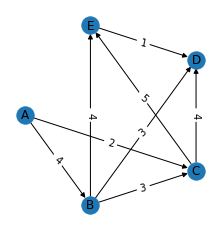

In [3]:
g = nx.DiGraph()

g.add_edge('A', 'B', weight=4)
g.add_edge('A', 'C', weight=2)
g.add_edge('B', 'C', weight=3)
g.add_edge('B', 'D', weight=3)
g.add_edge('B', 'E', weight=4)
g.add_edge('C', 'D', weight=4)
g.add_edge('C', 'E', weight=5)
g.add_edge('E', 'D', weight=1)

ax = plt.axes()

nx.draw_networkx(
    g, ax=ax,
    pos=nx.shell_layout(g)
)
nx.draw_networkx_edge_labels(
    g, ax=ax, pos=nx.shell_layout(g),
    edge_labels=dict(((u, v), g[u][v]['weight'])
                     for u, v in g.edges)
)

ax.set_aspect(1)
ax.set_axis_off()


<div class="alert alert-hint">
    <b>Dijkstra algorithm</b>: Time to recall the principle of the algorithm!
</div>

Dijkstra algorithm is provided in `networkx`; a more advanced interface is also available if we want to unroll the algorithm. Execute the following cells to see an animation of Dijkstra's algorithm on the previous graph.

In [4]:
from matplotlib import animation

def anim_to_html(anim):
    plt.close(anim._fig)
    return anim.to_html5_video()

animation.Animation._repr_html_ = anim_to_html

In [5]:
fig, ax = plt.subplots()
ax.set_axis_off()
ax.set_aspect(1)

nx.draw_networkx(
    g, ax=ax,
    pos=nx.shell_layout(g)
)

def animate(i):

    predecessors, _ = nx.shortest_paths.dijkstra_predecessor_and_distance(g, 'A', i)
    nx.draw_networkx_edges(
        g, ax=ax, pos=nx.shell_layout(g),
        edgelist=[(succ, pred)
                  for pred in predecessors.keys()
                  for succ in predecessors[pred]],
        edge_color='crimson',
        width=2
    )
    nx.draw_networkx_edge_labels(
        g, ax=ax, pos=nx.shell_layout(g),
        edge_labels=dict(((u, v), g[u][v]['weight'])
                         for u, v in g.edges)
    )
    return []

animation.FuncAnimation(fig, animate, frames=15,
                        interval=750, blit=True)


# A study case on the subway path finding problem

In this study case, we will be using the [RATP Open Data](https://data.ratp.fr/explore/dataset/offre-transport-de-la-ratp-format-gtfs/) service. You will find in the `data/` directory the `RATP_GTFS_LINES.zip` archive which can be found on the website.

The [GTFS format](https://en.wikipedia.org/wiki/General_Transit_Feed_Specification) is a format to communicate about transport services. Look at the `OffreDeTransport_GTFS_RATP.pdf` file in the `data/` directory to have explanations on how the data is structured.

The following script parses the archive and creates four dictionaries:

 - `stations` contains information about the stations (id, name, lat/lon positions);
 - `stop_times` contains train schedules for each station (stop_id, trip_id, arrival_time);
 - `trips` contains a one-to-n relationship between trips and routes (one trip_id per day, several trip_id for one route_id);
 - `transfers` contains minimum transfer times (walking time) from one station to another (more precisely)

Please note:

 - all dictionaries are indexed by the name of the line (`METRO_13`, `RER_B`);
 - the same station **may have several stop_id and several lat/lon coordinates**. The stop_id is associated to a subway platform rather than to a station building;
 - bus lines have been ignored in order to keep a map readable but the archive contains all you need to build your own pathfinding app with the full network information (you may want to also include [this](https://ressources.data.sncf.com/explore/dataset/sncf-transilien-gtfs/information/) or [this](https://data.toulouse-metropole.fr/explore/dataset/tisseo-gtfs/table/) information);
 - we use a [Lambert 93](https://fr.wikipedia.org/wiki/Projection_conique_conforme_de_Lambert#Projections_officielles_en_France_m%C3%A9tropolitaine) projection to convert lat/lon to x-y coordinates;
 - **you may use euclidean distance on x-y coordinates**.

<div class="alert alert-danger">
    <b>Warning:</b> The following looks long but all the work has been done for you. The real work starts after the first map of the subway network.
</div>

In [6]:
# You must execute this cell.
#
# This contains many useful functions

%run shortest_paths.py

C:\Users\Kinza\anaconda3\envs\sdd\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\Kinza\anaconda3\envs\sdd\lib\site-packages\pyproj\crs\crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


You may explore the four tables for metro line 1 as follows:

In [7]:
from IPython.display import display, HTML

display(HTML("<h4>Stations on METRO_1</h4>"))
display(stations['METRO_1'].head())

display(HTML("<h4>Stop times on METRO_1</h4>"))
display(stop_times['METRO_1'].head())

display(HTML("<h4>Trips on METRO_1</h4>"))
display(trips['METRO_1'].head())

display(HTML("<h4>Transfer times on METRO_1</h4>"))
display(transfers['METRO_1'].head())

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station
0,2371,NaN,Nation,Terre-plein face au 3 place de la Nation - 75112,48.848111,2.398004,0,NaN
1,1832,NaN,Nation,Terre-plein face au 3 place de la Nation - 75112,48.848111,2.398004,0,NaN
2,2170,NaN,Concorde,Place de la Concorde - 75108,48.865678,2.321194,0,NaN
3,2062,NaN,Bastille,Rue de la Roquette - 75104,48.852976,2.369219,0,NaN
4,2331,NaN,Louvre-Rivoli,Amiral de Coligny (8 rue de l') - 75101,48.860880,2.340973,0,NaN


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,shape_dist_traveled
0,10025335431078871,14:01:00,14:01:00,2035,1,NaN,NaN
1,10025335431078871,14:03:00,14:03:00,2067,2,NaN,NaN
2,10025335431078871,14:04:00,14:04:00,1725,3,NaN,NaN
3,10025335431078871,14:06:00,14:06:00,1751,4,NaN,NaN
4,10025335431078871,14:07:00,14:07:00,1832,5,NaN,NaN


,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,shape_id
0,1577980,2533543,10025335431078871,104,104,0,NaN
1,1577980,2533545,10025335451078871,104,104,0,NaN
2,1577980,2533546,10025335461078871,104,104,0,NaN
3,1577980,2533548,10025335481078871,104,104,0,NaN
4,1577980,2533549,10025335491078871,104,104,0,NaN


,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,4037246,2429,2,225
1,3765289,1751,2,252
2,7176243,1832,2,277
3,4996981,2062,2,209
4,4037177,2443,2,215


# Basic graph of the network

Now, we got all we need to build a first basic graph of the network.

You will fill the graph with more information later so **take the time to understand what happens here**:

In [8]:
# Paris RATP graph

g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the graph
        # (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

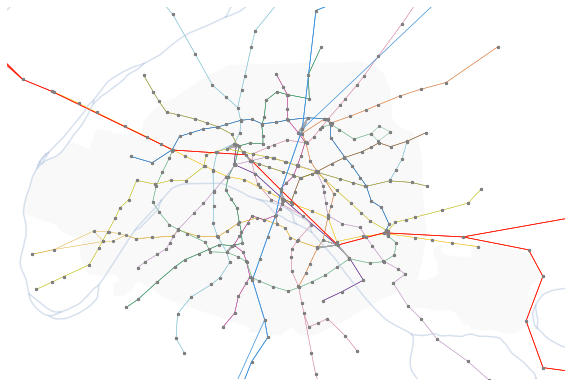

In [9]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 10),
)

# This function is provided together with the graph
plot_ratp(ax, g)

# Adding costs between stations 

Here the cost is the distance between two stations

In [10]:
# Paris RATP graph definition
# Add now the distance information

def distance(i1, i2):
    x1, y1 = pos[i1]
    x2, y2 = pos[i2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        for first, second in zip(sequence[:-1], sequence[1:]):
            dist = distance(first,second)
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # we store distance between two stations
                distance=dist,
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the graph
        # (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

# Finding the shortest path

In [11]:
# Look at the script if you want to know more about this function
%run shortest_path.py

<div class="alert alert-warning">
    Use Dijkstra's algorithm to find the shortest path between Félix Faure and Robespierre. 
</div>

In [12]:
results = shortest_path(g,"Félix Faure","Robespierre",nx.algorithms.shortest_paths.weighted.dijkstra_path)

assert(results["weight"] == 17)

NameError: name 'search_station' is not defined

# Plot the shortest path

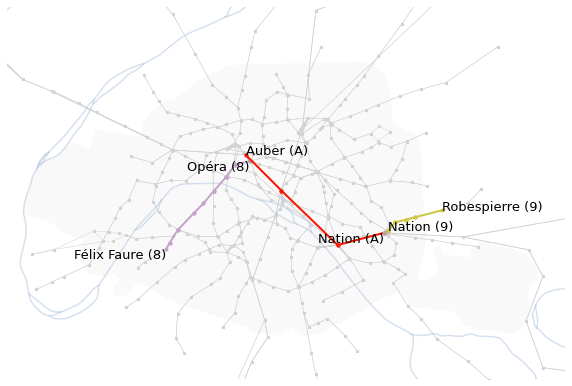

In [ ]:
# Plot the solution for Dijkstra's algorithm with distance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')
plot_path(
    ax, g, shortest_path(
        g, 'Félix Faure', 'Robespierre',
        nx.algorithms.shortest_paths.weighted.dijkstra_path,
        weight='distance'
    )
)

# A* algorithm instead of Dijkstra

<div class="alert alert-warning">
  Use the A* algorithm to find the shortest path between Félix Faure and Robespierre.
</div>

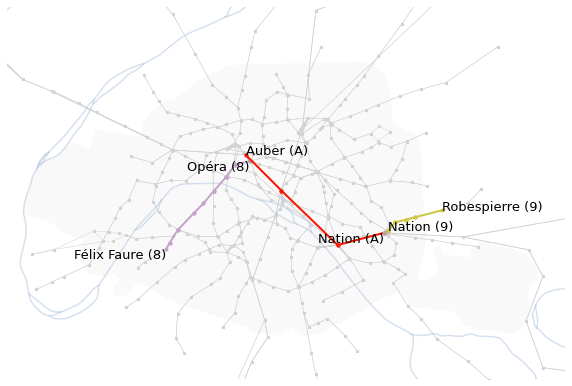

In [ ]:
# Write your code for A* here.
# Plot the solution for Dijkstra's algorithm with distance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plot_ratp(ax, g, color='lightgrey')
plot_path(
    ax, g, shortest_path(
        g, 'Félix Faure', 'Robespierre',
        nx.algorithms.shortest_paths.astar_path,
        weight='distance',
        heuristic=distance
    )
)

# Comparison between Dikstra and A*

<div class="alert alert-warning">
  Is A* algorithm faster than Dijkstra algorithm here?
</div>

In [ ]:
%%timeit
shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.dijkstra_path,
    weight='distance'
)

12.4 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='distance',
    heuristic=distance
)

16.1 ms ± 594 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
astar = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='distance',
    heuristic=distance,
)

dijkstra = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    # A* without heuristic is equivalent to Dijkstra
    nx.shortest_paths.astar_path,
    weight='distance',
)

# of course the result is the same!
astar['weight'], dijkstra['weight']

(12638.419059985401, 12638.419059985401)

In [ ]:
# Number of nodes explored
astar['counter'], dijkstra['counter']

(609, 609)

An animation to watch the evolution of both algorithms

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plot_ratp(ax1, g, color='lightgrey')
plot_ratp(ax2, g, color='lightgrey')

ax1.set_title("Dijkstra algorithm", fontsize=15)
ax2.set_title("A* algorithm", fontsize=15)

def animate():
    dijkstra_animate = animate_path(ax1, dijkstra)
    astar_animate = animate_path(ax2, astar)

    def animate_both(i):
        return dijkstra_animate(i) + astar_animate(i)

    return animate_both

animation.FuncAnimation(
    fig, animate(),
    frames=150, interval=100, blit=True
)

# Heuristic Distance

In [ ]:
g = nx.DiGraph()

# for each subway line
for line_nb, trip in trips.items():

    # for each different trip
    for trip_id in trip.drop_duplicates('route_id').trip_id:

        # Note:
        #   - we should use "trip_headsign" rather than "route_id"
        #     but the map gets confusing outside Paris
        #   - inside Paris, the graph we build here is still correct

        sequence = list(
            # get the list of stop_id in orders
            stop_times[line_nb]
            .query(f'trip_id == {trip_id}')
            .sort_values('stop_sequence')
            .stop_id
        )

        times = list(
            sum(
                int(a) * 60 ** (2 - i)  # h * 3600 + m * 60 + s
                for i, a in enumerate(times.split(':'))
            )
            for times in (
                    stop_times[line_nb]
                    .query(f'trip_id == {trip_id}')
                    .arrival_time.values
            )
        )

        for first, second, t1, t2 in zip(sequence[:-1], sequence[1:],
                                         times[:-1], times[1:]):
            g.add_edge(
                first, second,
                # we store 'RER' or 'METRO' for printing it differently
                type=line_nb.split('_')[0],
                # add distance information
                distance=distance(first, second),
                # add duration information
                duration=t2 - t1,
                # line_colors is provided as is
                color=line_colors[line_nb]
            )

# for each subway line
for line_nb, transfer in transfers.items():

    # parse the lines of the table in order
    for _, line in transfer.iterrows():

        first, second = line.from_stop_id, line.to_stop_id

        # add an edge for each connection if both nodes already exists in the
        # graph (remember there are a lot of bus stations we chose to ignore)
        if first in g.nodes and second in g.nodes:
            g.add_edge(
                first, second,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )
            g.add_edge(
                second, first,
                type='CONNECTION',
                distance=distance(first, second),
                duration=line.min_transfer_time,
                color='#aaaaaa'
            )

In [32]:
# Run both algorithms and print paths lengths.

dijkstra = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.dijkstra_path,
    weight='duration'
)

astar = shortest_path(
    g, 'Félix Faure', 'Robespierre',
    nx.shortest_paths.astar_path,
    weight='duration',
    heuristic=distance
)

# With a wrong heuristic, A* gives nonsense
astar['weight'], dijkstra['weight']

(1798, 1798)